# 📈 MVP Sprint Machine Learning & Analytics


Matrícula: 4052024001914

Nome: Maria Gabriela Ramos Neves



---



## Definição do Problema

### Importações, dowload do dataset e funções úteis

O Dataset escolhido foi o "Animals-10" que contém imagens de 10 animais diferentes extraídas do Google. Ao total, ele posssui cerca de 28 mil imagens e pode ser encontrado no Kaggle.


In [1]:
# Download do dataset
!curl -L -o animals10.zip https://www.kaggle.com/api/v1/datasets/download/alessiocorrado99/animals10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  585M  100  585M    0     0   107M      0  0:00:05  0:00:05 --:--:--  122M


In [2]:
# Descompressão da base
!unzip -q ./animals10.zip -d ./Animals10_data

In [3]:
# TensorFlow keras
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, EfficientNetB7
from tensorflow.keras.models import Model

# Bibliotecas Auxiliares
import shutil
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image

%matplotlib inline

In [4]:
def train_test_split_images(source_dir, output_dir, translate_dict, test_size=0.2, random_state=42):
    """
    Divide imagens de um diretório fonte em sets de treino e teste (conforme porcentagem
    definida) e copia elas em um diretório de saída.
    Se o diretório de saída existe, ele é deletado e criado novamente.

    Parâmetros:
    - source_dir: Diretório fonte das imagens.
    - output_dir: Diretório de saída para onde as imagens serão copiadas e divididas.
    - translate_dict: Dicionário para traduzir os nomes das classes.
    - test_size: Porcentagem do dataset que será usada para teste.
    - random_state: Estado aleatório para split do dataset.
    """

    # Checa se o diretório fonte existe
    if not os.path.exists(source_dir):
        raise FileNotFoundError(f"Source directory '{source_dir}' does not exist.")

    # Checa se o diretório destino existe e se sim, o deleta e recria
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Cria os sets de treino e teste
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    # Loop por cada classe presente no diretório fonte
    for class_name in os.listdir(source_dir):
      class_name_tsltd = translate_dict[class_name]
      class_path = os.path.join(source_dir, class_name)

      # Pula se a variável selecionada não for um diretório
      if not os.path.isdir(class_path):
          continue

      # Cria pastas correspondentes às classes no diretório
      train_class_dir = os.path.join(train_dir, class_name_tsltd)
      test_class_dir = os.path.join(test_dir, class_name_tsltd)
      os.makedirs(train_class_dir)
      os.makedirs(test_class_dir)

      # Pega todas as imagens do diretório fonte
      image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

      # Divide elas em sets de treino e teste
      train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)

      # Copia as imagens de treino para a pasta destino
      for file in train_files:
          src = os.path.join(class_path, file)
          dst = os.path.join(train_class_dir, file)
          shutil.copy(src, dst)

      # Copia as imagens de teste para a pasta destino
      for file in test_files:
          src = os.path.join(class_path, file)
          dst = os.path.join(test_class_dir, file)
          shutil.copy(src, dst)

    print(f"Split completed for class: {class_name_tsltd} with {len(train_files)} train samples, {len(test_files)} test samples and total: {len(image_files)}")


In [5]:
def plot_training_history(history):
    """
    Plota as curvas de perda (loss) e acurácia (accuracy) de treino e validação.

    Parâmetros:
        history: Objeto de histórico retornado pelo método model.fit() do Keras.
    """

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
def plot_misclassified_images(model, test_generator, class_names, num_images=10):
    """
    Apresenta imagens classificadas erroneamente, sua classe predita e sua classe real.

    Parâmetros:
        model: Modelo da rede neural treinada.
        test_generator: ImageDataGenerator de teste ou validação com as imagens e labels.
        class_names: Lista dos nomes de classes correspondentes ao índice.
        num_images: Número de imagens para apresentar.
    """
    predictions = model.predict(test_generator, verbose=1)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes

    # Identifica os índices das amostras classificadas erroneamente
    misclassified_indices = np.where(predicted_labels != true_labels)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified images found.")
        return

    # Aleatoriza e limita o número de imagens a ser mostrada
    misclassified_indices = random.sample(list(misclassified_indices), min(num_images, len(misclassified_indices)))

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(misclassified_indices):
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}",
                  color="red")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### Tradução e Visualização dos dados

In [7]:
# Dicionário para traduzir os nomes das classes, originalmente em italiano

translate_classes = {"cane": "dog",
                     "cavallo": "horse",
                     "elefante": "elephant",
                     "farfalla": "butterfly",
                     "gallina": "chicken",
                     "gatto": "cat",
                     "mucca": "cow",
                     "pecora": "sheep",
                     "scoiattolo": "squirrel",
                     "ragno": "spider"
                     }

In [8]:
# Diretório onde as imagens estão originalmente (organizado da forma pasta/animal_1/imagens)

source_dir = '/content/Animals10_data/raw-img'

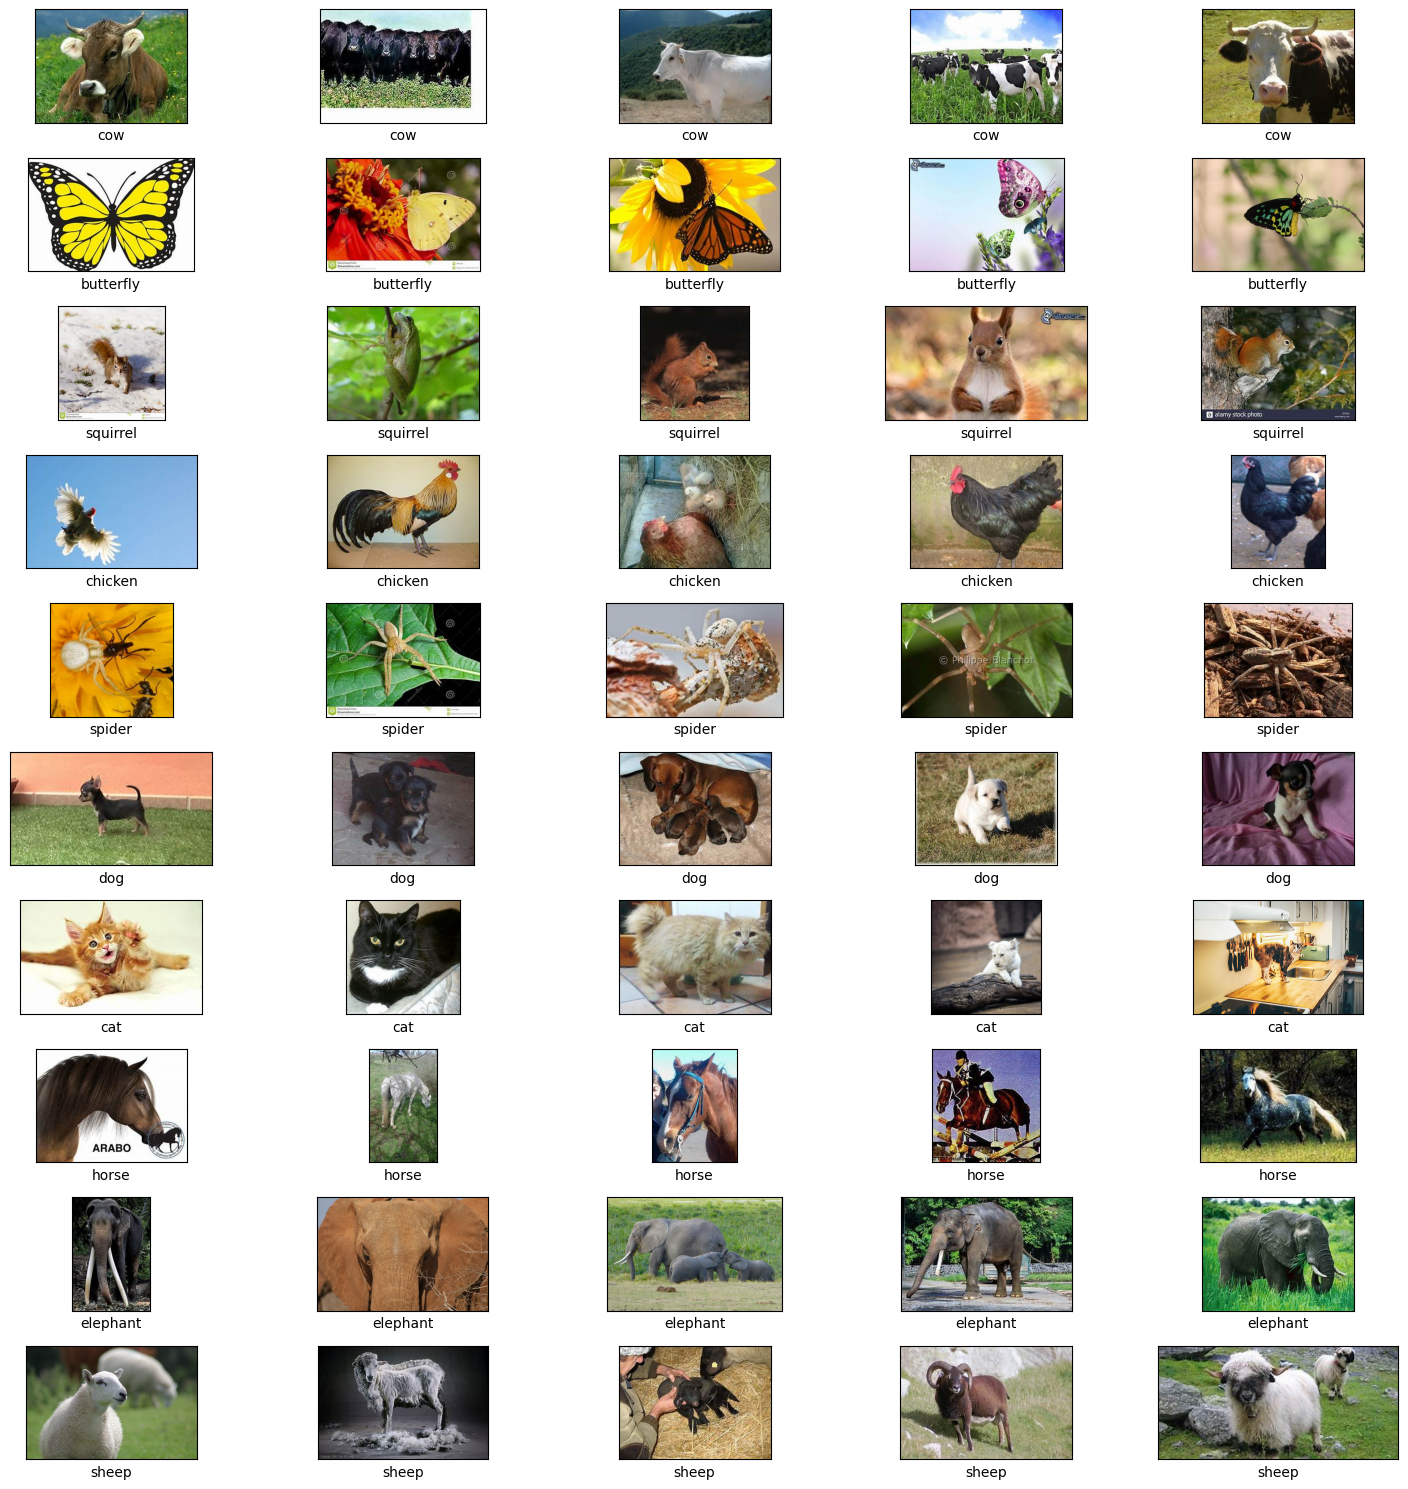

In [9]:
# Plot de algumas imagens com suas respectivas classes

dict_image = {}

for i in os.listdir(source_dir):
    dict_image[i] = os.listdir(os.path.join(source_dir, i))

fig, axs = plt.subplots(len(dict_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(source_dir)):
    images = np.random.choice(dict_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(source_dir, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=translate_classes[class_name], xticks=[], yticks=[])

fig.tight_layout()

### ✅ Checklist


*Objetivo: entender e descrever claramente o problema que está sendo resolvido.*

1. **Qual é a descrição do problema?**
- Classificação de 10 classes diferentes de animais através de imagens. As classes são: cachorro (dog), cavalo (horse), elefante (elephant), borboleta (butterfly), galinha (chicken), gato (cat), vaca (cow), ovelha (sheep), esquilo (squirrel) e aranha (spider).

2. **Você tem premissas ou hipóteses sobre o problema? Quais?**
- Inicialmente, que alguns animais devem se confundir devido ao ambiente em que aparecem nas imagens, semelhança de pelagem e de formato.

3. **Que restrições ou condições foram impostas para selecionar os dados?**
- Procurei por um dataset de imagens, que tivesse uma boa nota de usabilidade no kaggle e que abordasse um tema comum, facilitando a compreensão.

4. **Descreva o seu dataset (atributos, imagens, anotações, etc).**
- Ele possui cerca de 28 mil imagens separadas de forma desigual nas 10 classes citadas anteriormente (algumas classes tem menos de 2 mil amostras e outras tem quase 5 mil).
- Também, cada animal é representado de diferentes formas em suas classes (diferem de posição, cor, idade, ambiente, número e em alguns casos, existe a presença de outros elementos na imagem)
- As imagens parecem ter sido tiradas diretamente de uma pesquisa no Google, então é possível encontrar animais de classes diferentes em uma mesma imagem, também imagens que não correspondem à sua classe e imagens que não representam o animal real (são bichos de pelúcia, tatuagens etc).
- Abaixo estão alguns exemplos dos casos citados:

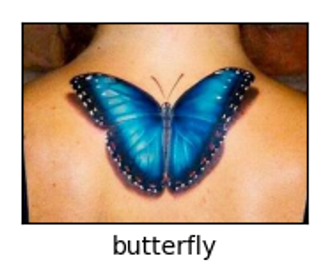

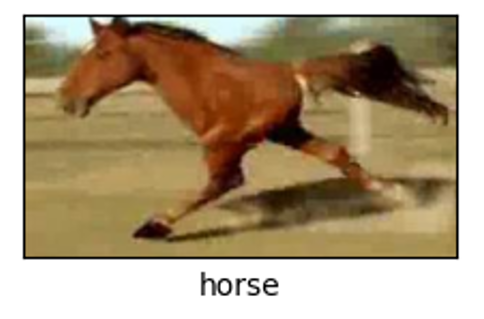

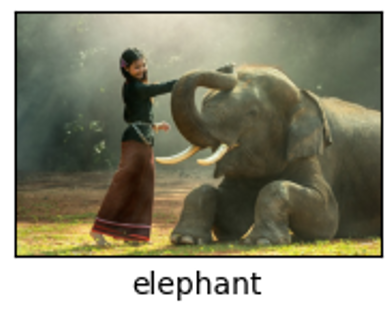

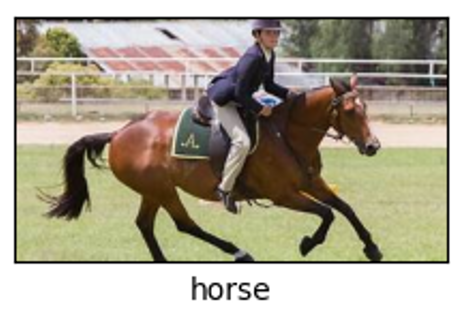

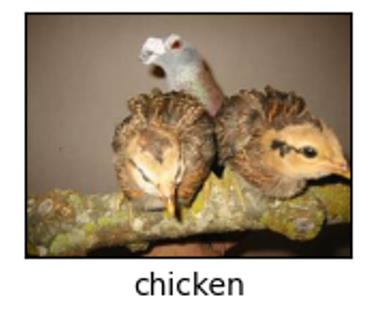

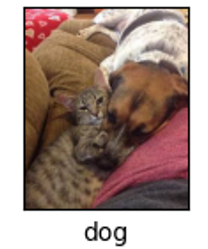

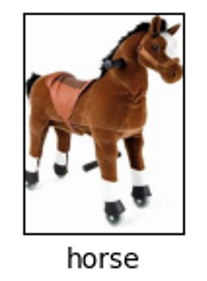

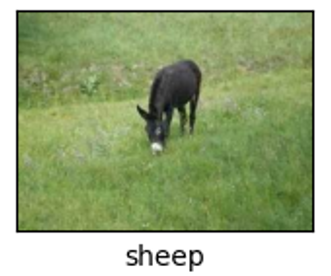

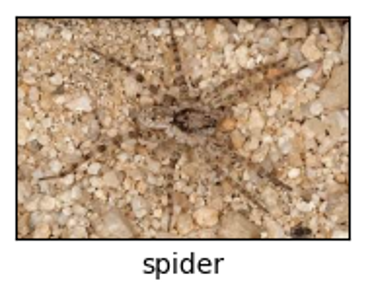

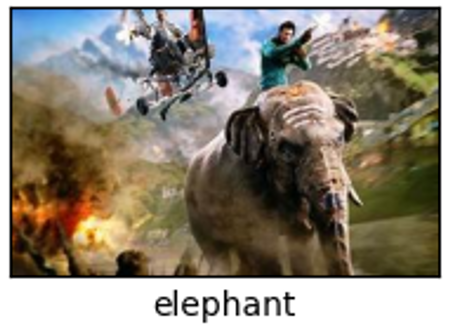





## Preparação de Dados


### Separação dos dados e tratamento

In [10]:
# Diretório onde as imagens serão coladas (organizado da forma pasta/train/animal_1/imagens e pasta/test/animal_1/imagens)
output_dir = '/content/split_dataset'

# Aplicação do train_test_split criado
train_test_split_images(source_dir, output_dir, translate_classes, test_size=0.2)

Split completed for class: sheep with 1456 train samples, 364 test samples and total: 1820


In [11]:
img_height = 224 # Escolhida por demanda da rede de transfer learning
img_width = 224 # Escolhida por demanda da rede de transfer learning
input_shape=(img_height, img_width, 3)
batch_size = 32

train_dir = '/content/split_dataset/train'
test_dir = '/content/split_dataset/test'

In [12]:
# Data Generators
train_datagen = ImageDataGenerator(
                  rescale=1./255,  # Normaliza os valores de pixel
                  shear_range=0.2,  # Tranformações para Data Augmentation
                  zoom_range=0.2,
                  rotation_range=40,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  horizontal_flip=True,
                  fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255) # Para o de teste, apenas normaliza os valores de pixel

# Flow from directory - gera label automaticamente pelo nome da pasta em que os arquivos estão
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')  # Nosso dataset é multiclasse

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', # Nosso dataset é multiclasse
    shuffle=False) # Importante para as futuras validações


Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


Por ser um dataset com poucas amostras, utilizei técnicas de data augmentation que vão gerar pequenas variações nas imagens existentes como zoom, rotação e inversão.

Também, pensando em compensar o desbalanceamento, utilizei o `sklearn.utils.class_weight` para atribuir diferentes pesos a cada classe e evitar que o modelo seja enviesado pelas classes majoritárias.

In [13]:
# Calcula os pesos de cada classe com base nos dados de treinamento, pensando em tratar o desbalanceamento

train_labels = train_generator.classes
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(zip(np.unique(train_labels), class_weights_array))

print("Class weights:", class_weights)

Class weights: {0: 1.2396684428656009, 1: 1.5695652173913044, 2: 0.844955609362389, 3: 1.4033512064343163, 4: 0.5382519280205655, 5: 1.8112456747404844, 6: 0.9979980934223069, 7: 1.4380494505494505, 8: 0.5429979253112033, 9: 1.406178643384822}


Para um treinamento mais eficiente e evitar overfitting, utilizei o callback
`EarlyStopping`. Ele monitora o desempenho do modelo e interrompe o treinamento quando ele para de melhorar, restaurando o melhor resultado alcançado.

O critério de parada definido foi `val_loss` com espera de 3 épocas antes de encerrar o treinamento e restauração dos melhores pesos.

In [14]:
# Definição do callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### ✅ Checklist

*Objetivo: realizar operações de preparação dos dados.*

1. **Separe o dataset entre treino e teste (e validação, se aplicável).**
- O dataset foi separado apenas em treino e teste (também utilizado como validação no treinamento) em decorrência do número reduzido de amostras em cada classe.

2. **Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.**
- Seria interessante usar métodos de validação cruzada por apresentarem uma estimativa mais confiável de desempenho, mas no estudo em questão teria um custo computacional elevado que o tornaria impraticável para o ambiente de execução usado.

3. **Verifique quais operações de transformação de dados (como normalização e padronização, transformação de imagens em tensores) são mais apropriadas para o seu problema e salve visões diferentes do seu dataset para posterior avaliação dos modelos.**
- Foram aplicadas as transformações de normalização dos pixels, translação horizontal, vertical, zoom aleatório e outras, mas utilizei no notebook final apenas a versão tratada dos dados pelo custo computacional que seria necessário para comparar as duas versões.

4. **Refine a quantidade de atributos disponíveis, realizando o processo de feature selection de forma adequada.**
- Não faz sentido para a análise / Não aplicável

## Modelagem e treinamento

### Abordagem 1 - Rede Neural

Como primeira abordagem, utilizei uma rede neural convolucional treinada do zero. O número de camadas convolucionais, de pooling e densas foi escolhido depois de alguns testes e levando em conta heurísticas.

A função de ativação escolhida foi a `ReLU` nas camadas convolucionais por ajudar a destacar padrões importantes das imagens e descartar informações ruidosas. Também foi usada na camada densa para combinar padrões aprendidos nas camadas anteriores.

O otimizador escolhido foi o `Adam` por ser amplamente utilizado em redes neurais profundas e ser adaptável.

A camada de saída tem ativação `softmax`, por permitir uma classificação multiclasse e possui 10 neurônios, correspondentes às 10 classes.

A função de perda usada foi a `categorical_crossentropy` por ser a mais indicada em classificação multiclasse.

Por fim, a métrica definida para acompanhamento durante o treinamento foi a acurácia, mas outras serão consideradas na avaliação final.

In [15]:
input_tensor = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

output = Dense(10, activation='softmax')(x)

In [16]:
model_nn = Model(inputs=input_tensor, outputs=output)

model_nn.compile(optimizer='adam',        # Utlização do otimizador Adam
              loss='categorical_crossentropy',  # Loss para classificação multiclasse
              metrics=['accuracy'])  # Acurácia como métrica de avaliação

In [17]:
history_nn = model_nn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


654/654 ━━━━━━━━━━━━━━━━━━━━ 253s 373ms/step - accuracy: 0.1753 - loss: 2.2767 - val_accuracy: 0.3970 - val_loss: 1.7029
Epoch 2/15
  1/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4062 - loss: 2.0809

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4062 - loss: 2.0809 - val_accuracy: 0.5600 - val_loss: 1.5740
Epoch 3/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 242s 366ms/step - accuracy: 0.3735 - loss: 1.7331 - val_accuracy: 0.4810 - val_loss: 1.4663
Epoch 4/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.5000 - loss: 1.5162 - val_accuracy: 0.3600 - val_loss: 1.8229
Epoch 5/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 241s 365ms/step - accuracy: 0.4306 - loss: 1.5801 - val_accuracy: 0.5268 - val_loss: 1.3666
Epoch 6/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.3750 - loss: 1.8153 - val_accuracy: 0.2800 - val_loss: 1.7898
Epoch 7/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 242s 366ms/step - accuracy: 0.4741 - loss: 1.4682 - val_accuracy: 0.5098 - val_loss: 1.4002
Epoch 8/15
654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.5312 - loss: 1.2819 - val_accuracy: 0.3600 - val_loss: 1.8483


### Abordagem 2 - Transfer Learning



A segunda abordagem utilizou a técnica de *Transfer Learning*, onde se aproveita uma rede neural pré-treinada (capaz de reconhecer bem padrões) como ponto inicial e se inserem camadas ao final para adaptar a rede ao problema em questão. É a abordagem mais promissora dado o número limitado de amostras

O modelo pré-treinado escolhido foi o `MobileNetV2`, que possui uma arquitetura mais leve e eficiente, porque apresentou o melhor resultado nas métricas, mas também foram testados os modelos `ResNet50`, `VGG16` e `EfficientNetB7`.

Os pesos usados foram do dataset `ImageNet`, que contém milhões de imagens classificadas em mil categorias.

In [18]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Congela o modelo base para que não seja treinado novamente
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Camadas personalizadas que irão adaptar a rede á tarefa desejada
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)

output = Dense(10, activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=output)

model_tl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
history_tl = model_tl.fit(
    train_generator,
    epochs=50,
    class_weight=class_weights,
    validation_data=validation_generator,
    callbacks=[early_stopping],
)

Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 269s 387ms/step - accuracy: 0.7987 - loss: 0.6417 - val_accuracy: 0.9405 - val_loss: 0.1872
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 242s 366ms/step - accuracy: 0.8915 - loss: 0.3349 - val_accuracy: 0.9374 - val_loss: 0.2082
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 242s 365ms/step - accuracy: 0.9019 - loss: 0.2955 - val_accuracy: 0.9382 - val_loss: 0.1986
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 242s 366ms/step - accuracy: 0.9136 - loss: 0.2597 - val_accuracy: 0.9464 - val_loss: 0.1696
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 241s 365ms/step - accuracy: 0.9174 - loss: 0.2540 - val_accuracy: 0.9435 - val_loss: 0.1714
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 244s 368ms/step - accuracy: 0.9213 - loss: 0.2446 - val_accuracy: 0.9473 - val_loss: 0.1717
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 238s 359ms/step - accuracy: 0.9204 - loss: 0.2373 - val_accuracy: 0.9393 - val_loss: 0.1969


### ✅ Checklist

*Objetivo: construir modelos para resolver o problema em questão.*

1. **Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas.**
- O algoritmo mais indicado seria uma rede neural convolucional com *transfer learning*, mas uma rede neural convolucional treinada do zero também foi testada. As justificativas e os detalhes se encontram no início de cada abordagem.

2. **Há algum ajuste inicial para os hiperparâmetros?**
- Sim, as duas abordagens passaram por diversos ajustes nos hiperparâmetros até chegar na arquitetura escolhida e esses ajustes foram responsáveis por uma grande melhora na acurácia.

3. **O modelo foi devidamente treinado? Foi observado problema de underfitting?**
- Não consegui identificar sinais claros de underfitting nos modelos. A partir das curvas de perda e acurária (apresentadas na seção de resultados), é possível perceber que, em geral, os modelos conseguiram aprender. Existem muitas oscilações na validação que sugerem um dataset ruidoso ou pequeno, ou seja, é uma observação que condiz com o que foi apresentado anteriormente.

4. **É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.**
- Sim, os ajustes foram feitos e as escolhas se deram em função de como afetavam a acurácia dos modelos.

5. **Há algum método avançado ou mais complexo que possa ser avaliado?**
- Gostaria de tentar uma abordagem com YOLO, já que muitas imagens são ruidosas e possuem mais de um elemento. A detecção eficiente de objetos que os modelos YOLO oferecem, poderia melhorar a classificação dos animais que este estudo não conseguiu classificar corretamente.

6. **Posso criar um comitê de modelos diferentes para o problema (ensembles)?**
- Sim, seria possível.

## Avaliação de Resultados

### Abordagem 1 - Rede Neural

#### Curvas de perda e acurácia

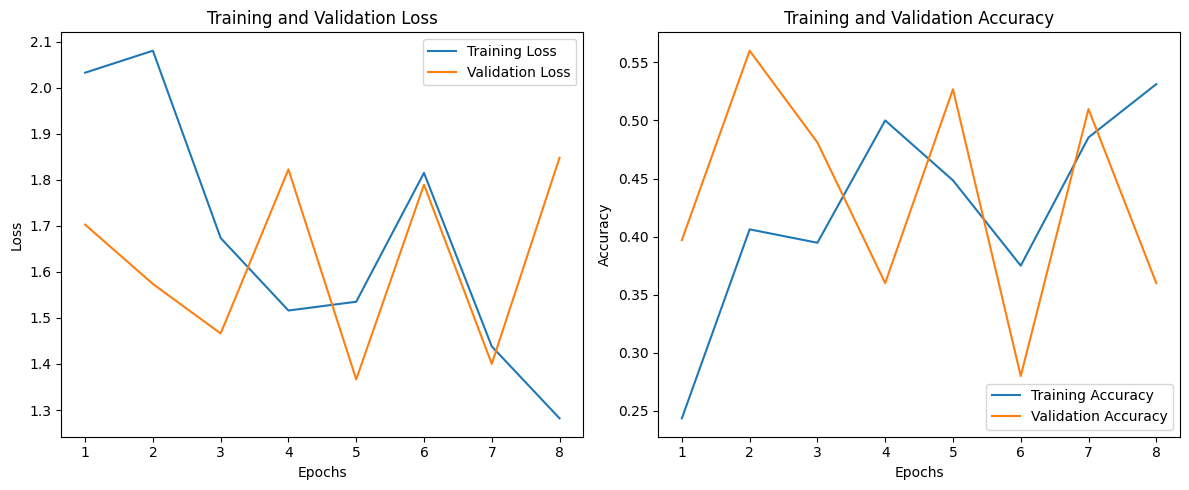

In [21]:
# Plot das curvas de perda e acurácia durante o treinamento

plot_training_history(history_nn)

Avaliando as curvas de perda (*loss*) da primeira abordagem, percebe-se que, em geral, a perda de treinamento diminui ao longo das épocas, indicando que o modelo está aprendendo. A perda de validação oscila de forma significativa provavelmente pelos dados de validação conterem amostras inconsistentes e ruidosas. As grandes flutuações podem ser sinal de que o modelo está tentadno aprender padrões de um dataset insocnsistente.

Já nas curvas de acurácia, a de treinamento sobe com o passar das épocas como esperado. A de validação diminiu, mas ambas oscilam de forma significativa provavelmente pela qualidade baixa dos dados de validação.

#### Reporte de Classificação

In [22]:
# Classes reais dos dados de validação
y_true_nn = validation_generator.classes

# Tranforma as probabilidades preditas em classes
y_pred_prob = model_nn.predict(validation_generator)
y_pred_nn = np.argmax(y_pred_prob, axis=1)

# Mapeia as classes através dos índices
class_indices = validation_generator.class_indices
class_names = list(class_indices.keys())  # Extract class names

# Gera o 'Classification Report' com diferentes métricas
print("\nClassification Report:")
print(classification_report(y_true_nn, y_pred_nn, target_names=class_names))


164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.71      0.70      0.70       423
         cat       0.38      0.28      0.32       334
     chicken       0.77      0.67      0.71       620
         cow       0.30      0.52      0.38       374
         dog       0.59      0.38      0.46       973
    elephant       0.34      0.61      0.44       290
       horse       0.51      0.45      0.48       525
       sheep       0.37      0.54      0.44       364
      spider       0.69      0.68      0.68       965
    squirrel       0.40      0.34      0.37       373

    accuracy                           0.53      5241
   macro avg       0.51      0.52      0.50      5241
weighted avg       0.55      0.53      0.53      5241



Em geral, a precisão (*precision*) indica a proporção de predições corretas de uma classe em relação ao total de predições dessa classe. A revocação (*recall*) idnica a proporção de predições corretas de uma classe em relação ao total de amostras reais da classe. O F1-Score é uma média harmônica de precisão e recall e é ideal para avaliar o desempenho quando existe desbalanceamento entre classes. Support representa o número total de amostras reais em cada classe do conjunto de teste.

Assim, esse modelo apresentou desempenho moderado com acurácia de 50%, ele teve facilidade em identificar algumas classes, como aranhas, mas apresentou dificuldade em identificar algumas outras como cachorros e gatos. Com um dataset maior e com menos ruídos, ele provavelmente apresentaria melhor desempenho

#### Matriz de Confusão

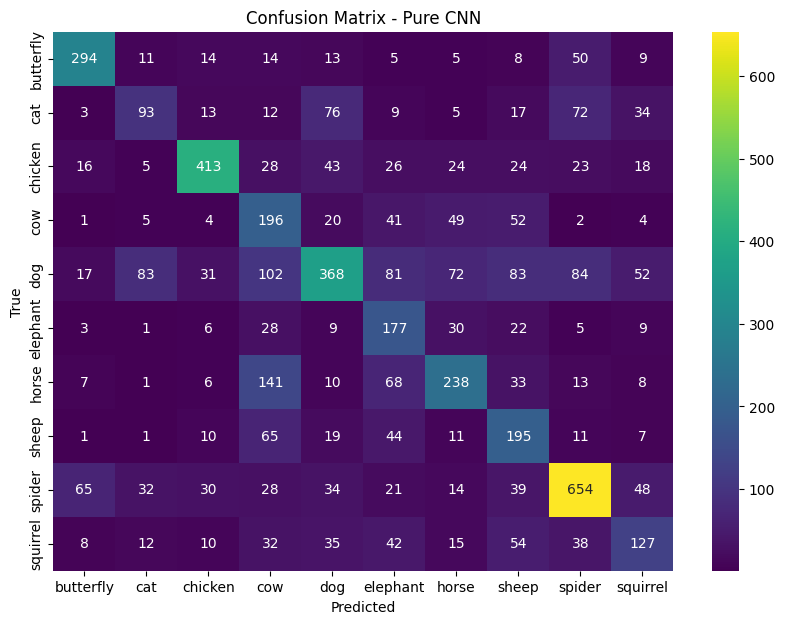

In [23]:
cm_nn = confusion_matrix(y_true_nn, y_pred_nn)

# Plot da matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='viridis', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Pure CNN')
plt.show()


A matriz de confusão deixa mais visual essa relação de classe real e classe predita

#### Exemplos de predições incorretas

164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


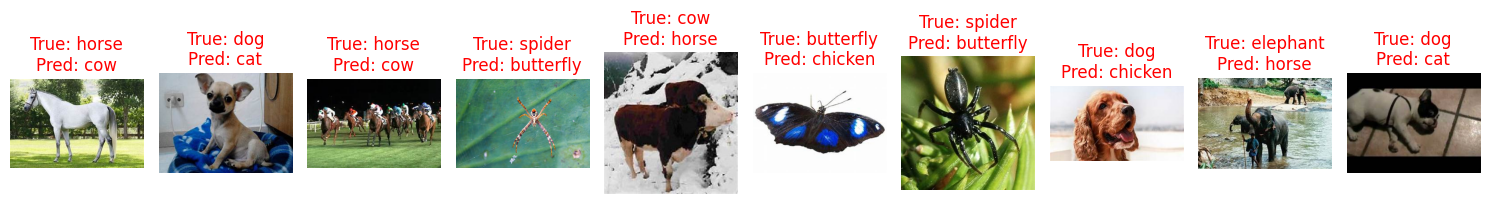

In [24]:
class_names_nn = list(validation_generator.class_indices.keys())
plot_misclassified_images(model_nn, validation_generator, class_names_nn, num_images=10)

No plot das imagens classificadas erroneamente, podemos ver que o modelo realmente teve dificuldade em identificar padrões das classes, já que confundiu animais que parecem diferenres nas imagens como as apresentadas abaixo.


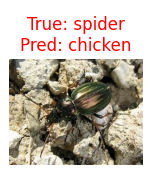

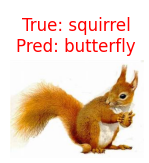

### Abordagem 2 - Transfer Learning


#### Curvas de perda e acurácia

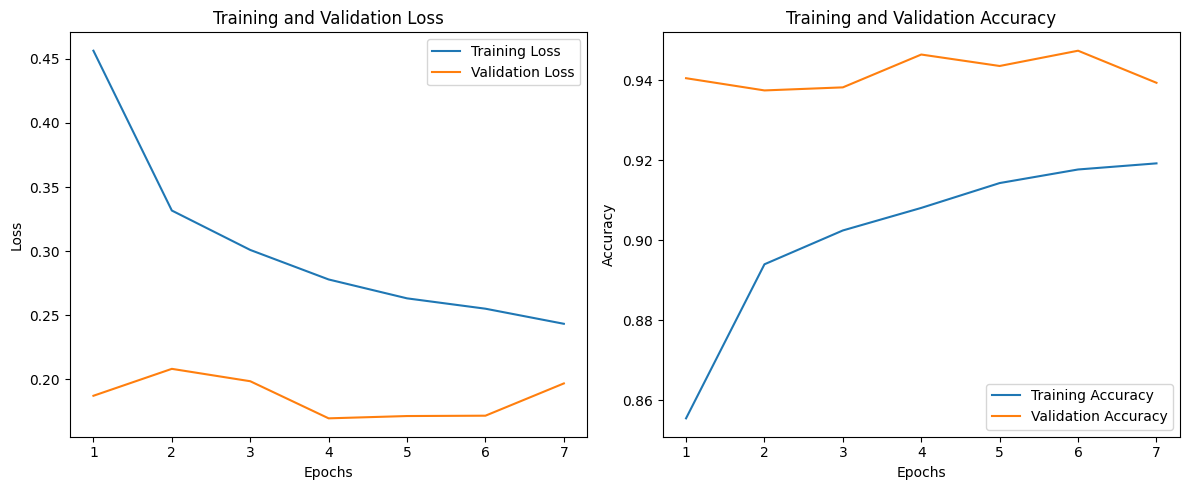

In [25]:
plot_training_history(history_tl)

Nas curvas de perda, percebemos que a de treinamento decai gradualmente e consistentemente no decorrer das épocas, o que é esperado para um modelo que está aprendendo. Já a de validação apresenta flutuações, indicando instabilidade e é significativamente menor que a perda de treinamento o que pode sugerir menor complexidade em relação ao treinamento.

A acurácia de treino aumenta consistentemente ao longo das épocas e apresenta estabilidade com pequenas variações. A de validação é maior que a de treinamento, reforçando a hipótese de que os dados de validação sejam menos desafiadores.

Em geral, é um modelo que apresenta desempenho bem melhor que a primeira abordagem.



#### Reporte de Classificação

In [26]:
# Classes reais dos dados de validação
y_true_tl = validation_generator.classes

# Tranforma as probabilidades preditas em classes
y_pred_prob = model_tl.predict(validation_generator)
y_pred_tl = np.argmax(y_pred_prob, axis=1)

# Mapeia as classes através dos índices
class_indices = validation_generator.class_indices
class_names = list(class_indices.keys())  # Extract class names

# Gera o 'Classification Report' com diferentes métricas
print("\nClassification Report:")
print(classification_report(y_true_tl, y_pred_tl, target_names=class_names))

164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.95      0.98      0.97       423
         cat       0.97      0.92      0.94       334
     chicken       0.97      0.97      0.97       620
         cow       0.80      0.92      0.86       374
         dog       0.98      0.92      0.95       973
    elephant       0.89      0.99      0.93       290
       horse       0.92      0.92      0.92       525
       sheep       0.96      0.89      0.92       364
      spider       0.99      0.97      0.98       965
    squirrel       0.93      0.98      0.95       373

    accuracy                           0.95      5241
   macro avg       0.94      0.95      0.94      5241
weighted avg       0.95      0.95      0.95      5241



Em geral, as métricas dessa abordagem apresentam grande melhora em relação à anterior, tanto nas métricas gerais quanto nas específicas de cada classe.

#### Matriz de Confusão

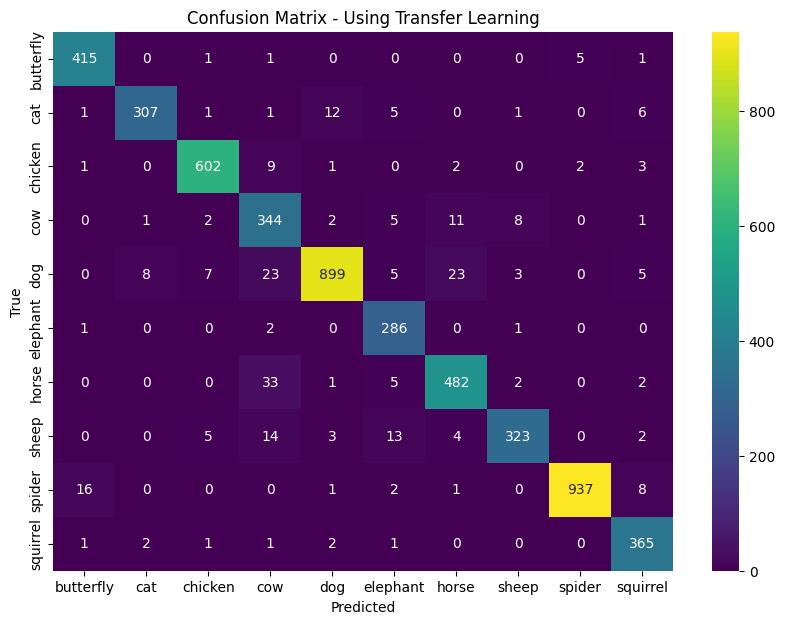

In [27]:
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='viridis', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Using Transfer Learning')
plt.show()

A matriz de confusão comprova a superioridade da abordagem 2 ao ver que a maior parte das amostras de cada classe foi classificada corretamente

#### Exemplos de predições incorretas

164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step


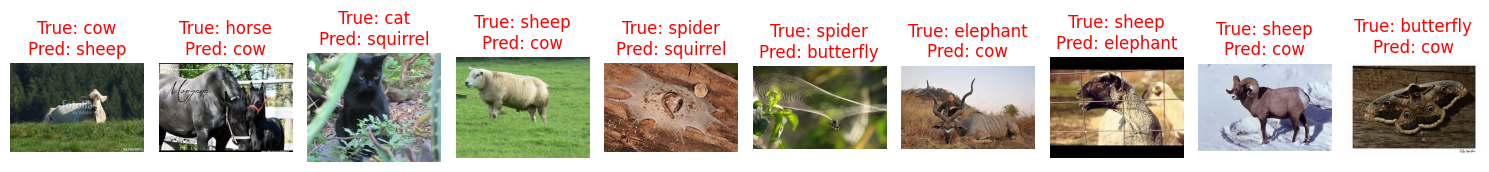

In [28]:
class_names = list(validation_generator.class_indices.keys())

plot_misclassified_images(model_tl, validation_generator, class_names, num_images=10)

### ✅ Checklist

*Objetivo: analisar o desempenho dos modelos gerados em dados não vistos (com a base de teste)*

1. **Selecione as métricas de avaliação condizentes com o problema, justificando.**
- Para este problema, a métrica mais utilizada foi a acurácia por ser aplicável e mais fácil de compeender, mas pensando na classificação multiclasse de dados desbalanceados em questão, também foram analisadas a precisão, o *recall* e o f1-score para compreender o comportamento do modelo em cada classe com mais detalhes.
- Além das métricas, foi analisada a matriz de confusão e algumas amostras classificadas de forma incorreta em cada modelo.
2. **Treine o modelo escolhido com toda a base de treino, e teste-o com a base de teste.**
- Ok
3. **Os resultados fazem sentido?**
- Fazem sentido e foram comentados em mais detalhes nas células anteriores.
4. **Foi observado algum problema de overfitting?**
- De forma geral, não
5. **Compare os resultados de diferentes modelos.**
- Foram comparadas suas abordagens.
6. **Descreva a melhor solução encontrada, justificando.**
- A melhor solução encontrada foi a que utiliza a técnica de *Transfer Learning* com a rede MobileNetV2 (abordagem 2). Ela apresentou não só a maior acurácia (95%), mas os melhores números em precisão, *recall*, f1-score e as melhores curvas de *loss* e acurácia. A matriz de confusão desse modelo comprova sua superioridade na classificação de cada classe.